<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
from mxnet.gluon.loss import L2Loss
import numpy as np
from mxnet import init
import mxnet.gluon.nn as nn
import gym
import matplotlib.pyplot as plt

# Hyper params

In [0]:
BATCH_SIZE=64           
LR=0.01                                                       
EPSILON=0.9                                                
GAMMA=0.9                              
TARGET_REPLACE_ITER=100                          
MEMORY_CAPACITY=1000

# env

In [0]:
env = gym.make('CartPole-v0').unwrapped                   
N_ACTIONS=env.action_space.n                       
N_STATES = env.observation_space.shape[0]    

# Qnet

In [0]:
def build_Q_net(net,num_actions):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(num_actions))
  return net

In [0]:
state = nd.random.normal(shape=(1,4))

In [6]:
q = build_Q_net(nn.HybridSequential(),N_ACTIONS)
q.initialize(init=init.Xavier(),force_reinit=True)
q(state)


[[-0.00842177  0.05223081]]
<NDArray 1x2 @cpu(0)>

# copy params

In [0]:
def copy_params(src, dst):
  for src_name,dst_name in zip(list(src.keys()),list(dst.keys())):
    print(src_name,dst_name)
    print(src.get(src_name).data())
    dst.get(dst_name).set_data(src.get(src_name).data())

# class DQN

In [0]:
class DQN(object):
  def __init__(self,N_ACTIONS):
    # one net
    self.eval_net = build_Q_net(nn.HybridSequential(),N_ACTIONS)
    self.eval_net.initialize(init=init.Xavier())
    
    # memory
    self.memory_counter = 0
    self.memory = np.zeros(shape=(MEMORY_CAPACITY, N_STATES*2 + 3))
    
    # trainer and loss_func 
    self.trainer = gluon.Trainer(self.eval_net.collect_params(),'Adam',{'learning_rate':0.001})
    self.loss_func = gluon.loss.L2Loss()

    # record history
    self.learn_step_counter = 0
    self.cost_his=[]
  
  def choose_action(self,x):
    # select best action
    if np.random.uniform() < EPSILON:
      action_value = self.eval_net(nd.array([x]))
      action = nd.argmax(action_value,axis=1).asscalar()
      return int(action)
    # select random action
    else:
      return np.random.randint(0,N_ACTIONS)
  
  def store_transition(self,s,a,r,d,s_):
    # add transition to memory
    transition = np.hstack((s,[a,r,d],s_))
    index = self.memory_counter % MEMORY_CAPACITY
    self.memory[index,:] = transition
    self.memory_counter += 1
  
  def learn(self):
    # record
    self.learn_step_counter += 1
    
    # sample a mini_batch_data
    sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
    b_memory = self.memory[sample_index,:]
    b_s = nd.array(b_memory[:,:N_STATES])
    b_a = nd.array(b_memory[:,N_STATES:N_STATES+1])
    b_r = nd.array(b_memory[:,N_STATES+1:N_STATES+2])
    b_d = nd.array(b_memory[:,N_STATES+2:N_STATES+3])
    b_s_= nd.array(b_memory[:,-N_STATES:])
    
    # caculate gradient
    with mx.autograd.record():
      Q_sp = nd.max(self.eval_net(b_s_),axis=1)
      Q_sp = Q_sp * (nd.ones(BATCH_SIZE)-b_d)
      Q_s_array = self.eval_net(b_s)
      Q_s = nd.pick(Q_s_array,b_a,1)
      loss = (Q_s - (b_r + GAMMA * Q_sp))**2
    
    # loss backward and trainer step
    loss.backward()
    self.trainer.step(BATCH_SIZE)
    
    # record loss history
    self.cost_his.append(nd.mean(loss).asscalar())
  
  def plot_cost(self):
     plt.plot(np.arange(len(self.cost_his)), self.cost_his)
     plt.ylabel('Cost')
     plt.xlabel('training steps')
     plt.show()

In [9]:
all_rewards = []
avg_rewards = []
dqn = DQN(N_ACTIONS)
for i_episode in range(200):
     s = env.reset()
     rewards = []
     while True:
         a = dqn.choose_action(s)
         s_, r, done, info = env.step(a)
         rewards.append(r) 
         dqn.store_transition(s,a,r,done,s_)
         if dqn.memory_counter > MEMORY_CAPACITY:
             dqn.learn()
         if done:
           print(i_episode,np.sum(rewards))
           all_rewards.append(np.sum(rewards))
           avg_rewards.append(np.mean(all_rewards[-10:]))
           break
         s = s_

0 43.0
1 86.0
2 23.0
3 23.0
4 31.0
5 30.0
6 33.0
7 49.0
8 53.0
9 47.0
10 60.0
11 49.0
12 39.0
13 39.0
14 23.0
15 34.0
16 43.0
17 55.0
18 68.0
19 42.0
20 46.0
21 30.0
22 27.0
23 41.0
24 38.0
25 24.0
26 24.0
27 68.0
28 78.0
29 53.0
30 30.0
31 42.0
32 25.0
33 51.0
34 22.0
35 54.0
36 21.0
37 48.0
38 43.0
39 36.0
40 19.0
41 50.0
42 69.0
43 54.0
44 25.0
45 41.0
46 30.0
47 104.0
48 57.0
49 57.0
50 22.0
51 52.0
52 48.0
53 26.0
54 42.0
55 58.0
56 35.0
57 42.0
58 61.0
59 89.0
60 71.0
61 133.0
62 55.0
63 76.0
64 144.0
65 55.0
66 62.0
67 62.0
68 74.0
69 46.0
70 26.0
71 55.0
72 48.0
73 53.0
74 97.0
75 73.0
76 76.0
77 45.0
78 162.0
79 80.0
80 88.0
81 67.0
82 70.0
83 51.0
84 64.0
85 224.0
86 232.0
87 126.0
88 75.0
89 135.0
90 76.0
91 99.0
92 110.0
93 134.0
94 47.0
95 75.0
96 204.0
97 38.0
98 86.0
99 82.0
100 77.0
101 115.0
102 83.0
103 114.0
104 81.0
105 78.0
106 131.0
107 103.0
108 39.0
109 94.0
110 157.0
111 156.0
112 125.0
113 127.0
114 163.0
115 137.0
116 128.0
117 140.0
118 155.0
119 40.0
120 13

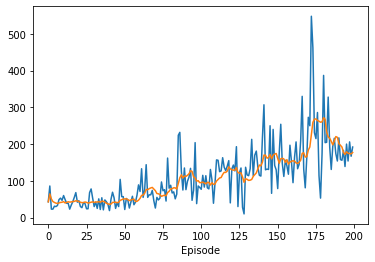

In [10]:
plt.plot(all_rewards)
plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.show()